In [1]:
from ase.io import read
import ase

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.graphs import MoleculeGraph
from pymatgen.analysis.local_env import OpenBabelNN, CovalentBondNN
from pymatgen.util.graph_hashing import weisfeiler_lehman_graph_hash

import networkx as nx
import os
from monty.serialization import loadfn
from glob import glob
import time
from tqdm import tqdm
import collections
import numpy as np
import matplotlib.pyplot as plt
import ast
import h5py


In [2]:
from radqm9_pipeline.modules import merge_data, read_elements, force_magnitude_filter, flatten

In [3]:
# sp_dir = '/pscratch/sd/m/mavaylon/new_pipe/new_sp/sp/sp_trajectories_old'

In [4]:
# merged_data=merge_data(sp_dir)

In [3]:
elements_dict = read_elements('/pscratch/sd/m/mavaylon/sam_ldrd/radqm9_pipeline/src/radqm9_pipeline/modules/elements.pkl')

In [3]:
# elements_dict

In [4]:
# h5_spi_dir='/pscratch/sd/m/mavaylon/new_pipe/sp_raw_data.h5'

In [5]:
# merged_file = h5py.File(h5_spi_dir, 'r')


In [6]:
# merged_file.close()

In [ ]:
# merged_raw_data=[]
# for point in tqdm(k_merged_file['config_batch_0']['raw']):
#     point = ast.literal_eval(point.decode('utf-8'))
#     merged_raw_data.append(point)

In [10]:
import h5py
import ast
merged_file = h5py.File(h5_spi_dir, 'r')

merged_raw_data=[]
for point in tqdm(merged_file['raw_data']['raw']):
    point = ast.literal_eval(point.decode('utf-8'))
    merged_raw_data.append(point)

100%|██████████| 3371648/3371648 [46:20<00:00, 1212.57it/s]  


3371648

In [7]:
merged_file.close()

In [7]:
h5_spi_dir_clean='/pscratch/sd/m/mavaylon/new_pipe/sp_filtered_out_broken.h5'

In [8]:
import h5py
import ast
merged_file = h5py.File(h5_spi_dir_clean, 'r')


In [9]:
merged_data=[]
for point in tqdm(merged_file['good']['good_data']):
    point = ast.literal_eval(point.decode('utf-8'))
    merged_data.append(point)

100%|██████████| 3249471/3249471 [41:52<00:00, 1293.40it/s] 


In [10]:
len(merged_data)

3249471

In [8]:
3371648-len(merged_data)

122177

# Bucket Tracker:
Raw Data: 3371648

vac: 1685829
smd:1685819

(Remove Broken graphs) 3249471 (122177 total broken graphs)
* Broken graphs vac: 61089
    * optimized: 18871
    * vertical: 42218
* Broken graphs smd: 61088
    * optimized: 18871
    * vertical: 42217

(Total Ids with missing configs)[75] (How much data is missing) [total: 1425]

Bucket 3 Vac (after clean)
* 1624740

Bucket 4 SMD (after clean)
* 1624731


In [44]:
1624731+1624740

3249471

TODO:
1. Format solvent
2. Broken graph remove and metadata
3. Metadata for SP at each bucket
4. Metadata for traj at each bucket
5. write sp to xyz with all fields
6. h5 version of sp and traj
7. plot dist of sp and traj
8. chunked xyz and h5 for sp and traj
9. traj +1-1 data in xyz and h5
10. special sp data in xyz and h5


### Get metadata on broken graphs

In [4]:
broken_path ='/pscratch/sd/m/mavaylon/new_pipe/sp_broken.h5'

In [5]:
import h5py
import ast
broken_file = h5py.File(broken_path, 'r')



In [11]:
broken_file['broken'].keys()

<KeysViewHDF5 ['broken_data']>

In [6]:
merged_broken_data=[]
for point in tqdm(broken_file['broken']['broken_data']):
    point = ast.literal_eval(point.decode('utf-8'))
    merged_broken_data.append(point)

100%|██████████| 122177/122177 [01:37<00:00, 1250.47it/s]


In [8]:
solvent_convert(merged_broken_data)

100%|██████████| 122177/122177 [00:00<00:00, 2052581.43it/s]


[]

In [10]:
type_tagger(merged_broken_data)


100%|██████████| 122177/122177 [00:00<00:00, 1544926.48it/s]


In [11]:
vacuum_broken_data = []
smd_broken_data = []
solvents = []
for item in merged_broken_data:
    solv = item['solvent']
    solvents.append(solv)
    if solv == 'vacuum':
        vacuum_broken_data.append(item)
    elif solv == 'SMD':
        smd_broken_data.append(item)

In [12]:
len(vacuum_broken_data)

61089

In [13]:
len(smd_broken_data)

61088

In [14]:
vac_optimized_broken = []
vac_vertical_broken = []
for item in vacuum_broken_data:
    opt_type = item['sp_config_type']
    if opt_type == 'optimized':
        vac_optimized_broken.append(item)
    elif opt_type == 'vertical':
        vac_vertical_broken.append(item)

In [16]:
len(vac_optimized_broken)

18871

In [17]:
len(vac_vertical_broken)

42218

In [15]:
smd_optimized_broken = []
smd_vertical_broken = []
for item in smd_broken_data:
    opt_type = item['sp_config_type']
    if opt_type == 'optimized':
        smd_optimized_broken.append(item)
    elif opt_type == 'vertical':
        smd_vertical_broken.append(item)

In [18]:
len(smd_optimized_broken)

18871

In [19]:
len(smd_vertical_broken)

42217

## Process

In [11]:
def charge_spin_tag(data: list):
    """
    
    """
    
    for item in tqdm(data):
        item['charge_spin'] = str(item['charge'])+'_'+str(item['spin'])

In [12]:
charge_spin_tag(merged_data)

100%|██████████| 3249471/3249471 [00:02<00:00, 1382895.24it/s]


In [9]:
sol=[]
for item in tqdm(merged_data):
    sol.append(item['solvent'])
        


100%|██████████| 3249471/3249471 [00:01<00:00, 2661725.94it/s]


In [10]:
list(set(sol))

['SOLVENT=WATER', 'NONE']

In [13]:
def solvent_convert(data:list):
    unresolved = []
    for item in tqdm(data):
        solv  = item['solvent']
        if solv == 'NONE':
            item['solvent'] = 'vacuum'
        elif solv == 'SOLVENT=WATER':
            item['solvent'] = 'SMD'
        else:
            unresolved.append(item)
    return unresolved

In [14]:
solvent_convert(merged_data)

100%|██████████| 3249471/3249471 [00:01<00:00, 2454384.66it/s]


[]

In [17]:
solvent_convert(merged_raw_data)

100%|██████████| 3371648/3371648 [00:01<00:00, 2261149.03it/s]


[]

In [15]:
def type_tagger(data: list):
    for item in tqdm(data):
        if item['charge_spin'] == item['optimized_parent_charge_spin']:
            item['sp_config_type'] = 'optimized'
        else:
            item['sp_config_type'] = 'vertical'

In [16]:
type_tagger(merged_data)


100%|██████████| 3249471/3249471 [00:02<00:00, 1608198.22it/s]


In [17]:
def resolve_parent_charge_spin(data: list):
    for item in tqdm(data):
        item['optimized_parent_charge_spin']= item['optimized_parent_charge_spin'].split('_')

In [18]:
resolve_parent_charge_spin(merged_data)

100%|██████████| 3249471/3249471 [00:02<00:00, 1130859.51it/s]


In [19]:
merged_data[0]['optimized_parent_charge_spin']

['0', '3']

# IDS < 6 configs

In [15]:
len(merged_data)

3249471

In [32]:
bucket_mol_id2={}
for data in tqdm(merged_data):
    try:
        bucket_mol_id2[data['mol_id']].append(data)
    except KeyError:
        bucket_mol_id2[data['mol_id']] = [data]

100%|██████████| 3249471/3249471 [00:03<00:00, 1054375.85it/s]


In [33]:
mol_id_present_config = {}
for data in tqdm(merged_data):
    opt_parent = data['optimized_parent_charge_spin'][0]+data['optimized_parent_charge_spin'][1]
    try:
        data['mol_id']
        mol_id_present_config[data['mol_id']].append(data['charge_spin']+'_'+data['sp_config_type']+'_'+opt_parent+'_'+data['solvent'])
    except KeyError:
        mol_id_present_config[data['mol_id']] = [data['charge_spin']+'_'+data['sp_config_type']+'_'+opt_parent+'_'+data['solvent']]

100%|██████████| 3249471/3249471 [00:06<00:00, 466069.52it/s]


In [34]:
def find_duplicates(lst):
    counts = {}
    duplicates = []
    for item in lst:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1
    
    for item, count in counts.items():
        if count > 1:
            duplicates.append(item)
    
    return duplicates

In [35]:
ids_missing = []
for mol_id in tqdm(bucket_mol_id2):
    if len(bucket_mol_id2[mol_id])<6:
        ids_missing.append(mol_id)
        
    dup = find_duplicates(mol_id_present_config[mol_id])
    if len(dup)>0:
        if len(set(mol_id_present_config[mol_id])) < 6:
            ids_missing.append(mol_id)

100%|██████████| 541591/541591 [00:01<00:00, 454437.07it/s]


In [38]:
# ids_missing

In [36]:
len(set(ids_missing))

75

In [30]:
missing_data_q=0
for mid in ids_missing:
    missing_data_q+=6-len(bucket_mol_id2[mid])    

In [31]:
missing_data_q

75

# Fix ids with >24 configs


In [32]:
more_6 = []
for mol_id in tqdm(mol_id_present_config):
    if len(mol_id_present_config[mol_id])>6:
        more_6.append(mol_id)

100%|██████████| 541591/541591 [00:00<00:00, 2273315.92it/s]


In [33]:
len(more_6)

0

### check to see >6 are not duplicates

In [28]:
more_6_unique = []
more_6 = []

for mol_id in tqdm(bucket_mol_id2):
    if len(bucket_mol_id2[mol_id])>6:
        more_6.append(mol_id)
    else:    
        dup = find_duplicates(mol_id_present_config[mol_id])
        if len(dup)>0:
            if len(set(mol_id_present_config[mol_id])) > 6:
                more_6_unique.append(mol_id)

100%|██████████| 541591/541591 [00:00<00:00, 739793.24it/s]


In [29]:
len(more_6)

0

In [38]:
len(more_6_unique)

0

In [39]:
for mol_id in tqdm(bucket_mol_id2):
    if len(bucket_mol_id2[mol_id])==6:
        print(mol_id)
        break

  0%|          | 2073/541708 [00:00<00:00, 1219808.11it/s]

6ae088eabb2c3d63f917a2fc470e73df-C8H8O1-0-3


In [40]:
mol_id_present_config['6ae088eabb2c3d63f917a2fc470e73df-C8H8O1-0-3']

['-1_2_vertical_0_3_vacuum',
 '0_3_optimized_0_3_vacuum',
 '1_2_vertical_0_3_vacuum',
 '-1_2_vertical_0_3_SMD',
 '0_3_optimized_0_3_SMD',
 '1_2_vertical_0_3_SMD']

In [50]:
len(merged_data)

3262598

In [41]:
def resolve_duplicate_data(data: list):
    filtered_data = []
    
    bucket_mol_id={}
    for item in tqdm(data):
        try:
            bucket_mol_id[item['mol_id']].append(item)
        except KeyError:
            bucket_mol_id[item['mol_id']] = [item]
    
    mol_id_present_config = {}
    for item in tqdm(data):
        opt_parent = item['optimized_parent_charge_spin'][0]+item['optimized_parent_charge_spin'][1]

        item['dup_identifier'] = item['charge_spin']+'_'+item['sp_config_type']+'_'+opt_parent+'_'+item['solvent']
        try:
            mol_id_present_config[item['mol_id']].append(item['charge_spin']+'_'+item['sp_config_type']+'_'+opt_parent+'_'+item['solvent'])
        except KeyError:
            mol_id_present_config[item['mol_id']] = [item['charge_spin']+'_'+item['sp_config_type']+'_'+opt_parent+'_'+item['solvent']]
    
    # get unique set of configs for each key in mol_id_present_config to use as keys to sample from bucket_mol_id
    for mol_id in tqdm(bucket_mol_id):
        pool = list(set(mol_id_present_config[mol_id]))
        for item in pool:
            for point in bucket_mol_id[mol_id]:
                if point['dup_identifier'] == item:
                    filtered_data.append(point)
                    break
                
                
                
    return filtered_data

In [42]:
filtered_data = resolve_duplicate_data(merged_data)

100%|██████████| 541591/541591 [00:02<00:00, 181827.13it/s]


# Special sets

## Just the Doublets

In [43]:
doublet_data = []
for item in tqdm(filtered_data):
    if item['charge'] in [-1, 1]:
        doublet_data.append(item)

100%|██████████| 3249471/3249471 [00:02<00:00, 1367357.98it/s]


In [45]:
vacuum_doublet_data_data = []
smd_doublet_data_data = []
solvents = []
for item in doublet_data:
    solv = item['solvent']
    solvents.append(solv)
    if solv == 'vacuum':
        vacuum_doublet_data_data.append(item)
    elif solv == 'SMD':
        smd_doublet_data_data.append(item)

## Just the singlets

In [60]:
singlet_data = []
for item in tqdm(filtered_data):
    if item['charge'] in [0, -2, 2]:
        singlet_data.append(item)

100%|██████████| 3249471/3249471 [00:02<00:00, 1368610.21it/s]


In [61]:
len(singlet_data)

1632687

In [62]:
vacuum_singlet_data_data = []
smd_singlet_data_data = []
solvents = []
for item in singlet_data:
    solv = item['solvent']
    solvents.append(solv)
    if solv == 'vacuum':
        vacuum_singlet_data_data.append(item)
    elif solv == 'SMD':
        smd_singlet_data_data.append(item)

# ignore work

In [43]:
len(filtered_data)

3250173

In [44]:
3249471-len(filtered_data)

-702

In [46]:
bucket_mol_id3={}
for item in tqdm(filtered_data):
    try:
        bucket_mol_id3[item['mol_id']].append(item)
    except KeyError:
        bucket_mol_id3[item['mol_id']] = [item]
    

100%|██████████| 3250173/3250173 [00:03<00:00, 1006126.75it/s]


In [47]:
mol_id_present_config3 = {}
for data in tqdm(filtered_data):
    try:
        mol_id_present_config3[data['mol_id']].append(data['charge_spin']+'_'+data['sp_config_type']+'_'+data['optimized_parent_charge_spin']+'_'+data['solvent'])
    except KeyError:
        mol_id_present_config3[data['mol_id']] = [data['charge_spin']+'_'+data['sp_config_type']+'_'+data['optimized_parent_charge_spin']+'_'+data['solvent']]

100%|██████████| 3250173/3250173 [00:06<00:00, 496633.30it/s]


In [48]:
duppp=[]
for mol_id in tqdm(bucket_mol_id3):
    dup = find_duplicates(mol_id_present_config3[mol_id])
    if len(dup)>0:
        if len(set(mol_id_present_config3[mol_id])) != 6:
            duppp.append(mol_id)

100%|██████████| 541708/541708 [00:01<00:00, 437411.74it/s]


In [49]:
duppp

[]

In [14]:
bucket_mol_id={}
for data in tqdm(merged_data):
    try:
        bucket_mol_id[data['mol_id']].append(data)
    except KeyError:
        bucket_mol_id[data['mol_id']] = [data]

100%|██████████| 3371648/3371648 [00:02<00:00, 1633724.09it/s]


In [49]:
len(bucket_mol_id.keys())

561954

In [54]:
len(bucket_mol_id['4cb6251dd9a9dcd419fd732c6279d0b0-C6H6O3-0-3'])

6

In [13]:
# merged_data[0]

In [15]:
less_24=[]
for mol_id in bucket_mol_id:
    if len(bucket_mol_id[mol_id])<6:
        less_24.append(mol_id)

In [16]:
len(less_24)

76

In [ ]:
def find_duplicates(lst):
    counts = {}
    duplicates = []
    for item in lst:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1
    
    for item, count in counts.items():
        if count > 1:
            duplicates.append(item)
    
    return duplicates

In [33]:
mol_id_present_config = {}
for data in tqdm(merged_data):
    try:
        mol_id_present_config[data['mol_id']].append(data['charge_spin']+'_'+data['sp_config_type']+'_'+data['optimized_parent_charge_spin']+'_'+data['solvent'])
    except KeyError:
        mol_id_present_config[data['mol_id']] = [data['charge_spin']+'_'+data['sp_config_type']+'_'+data['optimized_parent_charge_spin']+'_'+data['solvent']]

100%|██████████| 3371648/3371648 [00:05<00:00, 656872.16it/s]


In [12]:
more_24 = []
for mol_id in tqdm(mol_id_present_config):
    if len(mol_id_present_config[mol_id])>24:
        more_24.append(mol_id)

100%|██████████| 133882/133882 [00:00<00:00, 2039337.61it/s]


In [13]:
len(more_24)

40389

In [14]:
# check for more than 24 that register as non-duplicates
set_mol_id_present_config = {}
for id_ in mol_id_present_config:
    set_mol_id_present_config[id_] = list(set(mol_id_present_config[id_]))

set_more_24 = []
for mol_id in tqdm(set_mol_id_present_config):
    if len(set_mol_id_present_config[mol_id])>24:
        set_more_24.append(mol_id)

100%|██████████| 133882/133882 [00:00<00:00, 2337750.96it/s]


In [17]:
len(set_more_24)
set_more_24[0]

116537

In [42]:
def remove_non_duplicate(dataset: list):
    """
    This method is to remove mol ids that have more than 24 non-duplicate data. 
    """
    mol_id_present_config = {}
    for data in tqdm(dataset):
        try:
            mol_id_present_config[data['mol_id']].append(data['charge_spin']+'_'+data['sp_config_type']+'_'+data['optimized_charge_spin']+'_'+data['solvent'])
        except KeyError:
            mol_id_present_config[data['mol_id']] = [data['charge_spin']+'_'+data['sp_config_type']+'_'+data['optimized_charge_spin']+'_'+data['solvent']]
    
    # check for more than 24 that register as non-duplicates
    set_mol_id_present_config = {}
    for id_ in mol_id_present_config:
        set_mol_id_present_config[id_] = list(set(mol_id_present_config[id_]))

    set_more_24 = []
    for mol_id in tqdm(set_mol_id_present_config):
        if len(set_mol_id_present_config[mol_id])>24:
            set_more_24.append(mol_id)
    
    clean_data = []
    for item in dataset:
        if item['mol_id'] not in set_more_24:
            clean_data.append(item)
    
    return clean_data

In [43]:
cleaner_data = remove_non_duplicate(merged_data)

100%|██████████| 133882/133882 [00:00<00:00, 2895888.86it/s]


In [44]:
len(merged_data)-len(cleaner_data)

5375

In [21]:
def find_duplicates(lst):
    counts = {}
    duplicates = []
    for item in lst:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1
    
    for item, count in counts.items():
        if count > 1:
            duplicates.append(item)
    
    return duplicates

In [46]:
def remove_duplicate_data(dataset: list):
    """
    This removes mol_ids that have duplicates resulting the set of the configs being less than 24.
    """
    mol_id_present_config = {}
    for data in tqdm(dataset):
        try:
            mol_id_present_config[data['mol_id']].append(data['charge_spin']+'_'+data['sp_config_type']+'_'+data['optimized_charge_spin']+'_'+data['solvent'])
        except KeyError:
            mol_id_present_config[data['mol_id']] = [data['charge_spin']+'_'+data['sp_config_type']+'_'+data['optimized_charge_spin']+'_'+data['solvent']]
    
    id_repeat = {}
    remove_ids = []
    for mol_id in mol_id_present_config:
        dup = find_duplicates(mol_id_present_config[mol_id])
        if len(dup)>0:
            id_repeat[mol_id] = dup
            if len(set(mol_id_present_config[mol_id])) < 24:
                remove_ids.append(mol_id)
    
    print(len(remove_ids))
    
    clean_data = []
    for item in tqdm(dataset):
        if item['mol_id'] not in remove_ids:
            clean_data.append(item)
    
    return clean_data

In [47]:
cleaner_data2=remove_duplicate_data(cleaner_data)

100%|██████████| 3513448/3513448 [00:03<00:00, 1020772.79it/s]


2510


100%|██████████| 3513448/3513448 [01:43<00:00, 33896.34it/s]


In [98]:
len(cleaner_data)-len(cleaner_data2)

In [103]:
len(cleaner_data2)

3452504

# Record ids with <24 configs

In [25]:
configs_24= ['2_1_vertical_1_2_SMD',
 '0_1_optimized_0_1_SMD',
 '2_1_vertical_1_2_vacuum',
 '0_3_optimized_0_3_vacuum',
 '-2_1_vertical_-1_2_vacuum',
 '-1_2_vertical_0_1_SMD',
 '-1_2_vertical_0_3_vacuum',
 '-1_2_optimized_-1_2_vacuum',
 '0_1_vertical_-1_2_vacuum',
 '0_1_optimized_0_1_vacuum',
 '0_3_optimized_0_3_SMD',
 '-1_2_optimized_-1_2_SMD',
 '1_2_optimized_1_2_SMD',
 '0_1_vertical_-1_2_SMD',
 '1_2_optimized_1_2_vacuum',
 '1_2_vertical_0_3_SMD',
 '0_1_vertical_1_2_SMD',
 '-1_2_vertical_0_1_vacuum',
 '-1_2_vertical_0_3_SMD',
 '-2_1_vertical_-1_2_SMD',
 '1_2_vertical_0_3_vacuum',
 '0_1_vertical_1_2_vacuum',
 '1_2_vertical_0_1_SMD',
 '1_2_vertical_0_1_vacuum']

In [13]:
sorted(config24)

['-1_2_optimized_-1_2_SMD',
 '-1_2_optimized_-1_2_vacuum',
 '-1_2_vertical_0_1_SMD',
 '-1_2_vertical_0_1_vacuum',
 '-1_2_vertical_0_3_SMD',
 '-1_2_vertical_0_3_vacuum',
 '-2_1_vertical_-1_2_SMD',
 '-2_1_vertical_-1_2_vacuum',
 '0_1_optimized_0_1_SMD',
 '0_1_optimized_0_1_vacuum',
 '0_1_vertical_-1_2_SMD',
 '0_1_vertical_-1_2_vacuum',
 '0_1_vertical_1_2_SMD',
 '0_1_vertical_1_2_vacuum',
 '0_3_optimized_0_3_SMD',
 '0_3_optimized_0_3_vacuum',
 '1_2_optimized_1_2_SMD',
 '1_2_optimized_1_2_vacuum',
 '1_2_vertical_0_1_SMD',
 '1_2_vertical_0_1_vacuum',
 '1_2_vertical_0_3_SMD',
 '1_2_vertical_0_3_vacuum',
 '2_1_vertical_1_2_SMD',
 '2_1_vertical_1_2_vacuum']

In [19]:
bucket_mol_id2={}
for data in tqdm(merged_data):
    try:
        bucket_mol_id2[data['mol_id']].append(data)
    except KeyError:
        bucket_mol_id2[data['mol_id']] = [data]

100%|██████████| 3371648/3371648 [00:02<00:00, 1575571.30it/s]


In [41]:
def disjoint_lists(list1):
    set1 = set(list1)
    set2 = set(configs_24)
    
    disjoint_set2 = set2 - set1  # Elements in set2 but not in set1
    
    return list(disjoint_set2)

In [18]:
mol_id_present_config = {}
for data in tqdm(merged_data):
    try:
        mol_id_present_config[data['mol_id']].append(data['charge_spin']+'_'+data['sp_config_type']+'_'+data['optimized_parent_charge_spin']+'_'+data['solvent'])
    except KeyError:
        mol_id_present_config[data['mol_id']] = [data['charge_spin']+'_'+data['sp_config_type']+'_'+data['optimized_parent_charge_spin']+'_'+data['solvent']]

100%|██████████| 3371648/3371648 [00:04<00:00, 775696.37it/s]


In [22]:
ids_missing = []
for mol_id in tqdm(bucket_mol_id2):
    if len(bucket_mol_id2[mol_id])<6:
        ids_missing.append(mol_id)
        
    dup = find_duplicates(mol_id_present_config[mol_id])
    if len(dup)>0:
        if len(set(mol_id_present_config[mol_id])) < 24:
            ids_missing.append(mol_id)

100%|██████████| 561954/561954 [00:00<00:00, 700644.49it/s]


In [43]:
# ids_missing=[]
# for mol_id in tqdm(bucket_mol_id2):
#     if len(bucket_mol_id2[mol_id])<24:
#         ids_missing.append(mol_id)

100%|██████████| 561954/561954 [00:00<00:00, 2206293.97it/s]


In [23]:
len(set(ids_missing))

76

1. Which configs are missing histogram in general. --> 24 bins x with log count y
2. How many vertical and how many optimized configs are missing in general
3. How many per optimized structure are missing
4. How many specfic pairs are missing within each optimized structure 

In [45]:
missing_config = {}
for id_ in set(ids_missing):
    try:
        missing_config[id_].append(disjoint_lists(mol_id_present_config[id_]))
    except KeyError:
        missing_config[id_] = disjoint_lists(mol_id_present_config[id_])

NameError: name 'configs_24' is not defined

In [53]:
missing_config[66651]

['0_1_vertical_-1_2_SMD',
 '-2_1_vertical_-1_2_SMD',
 '-1_2_optimized_-1_2_SMD',
 '-2_1_vertical_-1_2_vacuum',
 '-1_2_optimized_-1_2_vacuum',
 '0_1_vertical_-1_2_vacuum']

In [66]:
config2id = {}
for id_ in missing_config:
    for value in missing_config[id_]:
        try:
            config2id[value].append(id_)
        except KeyError:
            config2id[value] = [id_]

In [67]:
length = [len(config2id[x]) for x in config2id]

In [68]:
sum(length)

86790

Text(0, 0.5, 'Log Count')

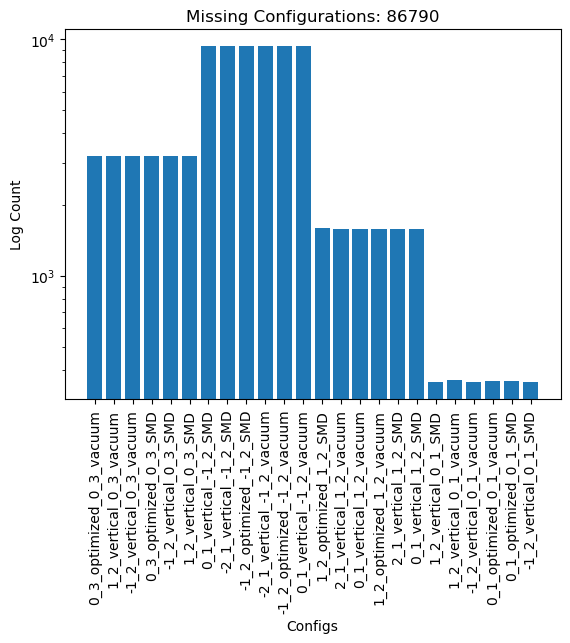

In [71]:
plt.bar(config2id.keys(), length)
plt.xticks(rotation=90)
plt.yscale('log')
# Adding title and labels
plt.title('Missing Configurations: 86790')
plt.xlabel('Configs')
plt.ylabel('Log Count')
# plt.ylabel('Count')

# Force Filter


You do not need to filter since these are all optimized points, which mean the forces are really small.

# Broken Graph Filter

In [113]:
def build_graph(species, position):
    atoms = ase.atoms.Atoms(symbols=species,
                            positions=position)
    mol = AseAtomsAdaptor.get_molecule(atoms)
    graph = MoleculeGraph.with_local_env_strategy(mol, OpenBabelNN())
    return graph

In [119]:
def sp_filter_broken_graphs(data: list):
    broken = []
    good = []
    
    for item in tqdm(data):
        if item['charge_spin'] == '0,1':
            continue
        else:
            graph = build_graph(item['species'], item['geometry'])
            connected = nx.is_connected(graph.graph.to_undirected())
            if not connected:
                broken.append(item)
            else:
                good.append(item)

    return good, broken

In [1]:
# filtered_good, broken = sp_filter_broken_graphs(merged_data)

In [ ]:
import h5py
with h5py.File('/pscratch/sd/m/mavaylon/new_pipe/sp_broken.h5', 'w') as file:
    g1 =file.create_group('broken')
    bbd=[]
    for item in broken:
        bbd.append(str(item))
    g1.create_dataset('broken_data',data=bbd)

In [ ]:
file.close()

In [ ]:
import h5py
with h5py.File('/pscratch/sd/m/mavaylon/new_pipe/sp_filtered_out_broken.h5', 'w') as file:
    g1 =file.create_group('good')
    bbd=[]
    for item in filtered_good:
        bbd.append(str(item))
    g1.create_dataset('good_data',data=bbd)

In [2]:
file_good = h5py.File('/pscratch/sd/m/mavaylon/new_pipe/sp_filtered_out_broken.h5', 'r')

In [ ]:
import h5py

merged_data=[]
for point in tqdm(file_good['good']['good_data']):
    point = ast.literal_eval(point.decode('utf-8'))
    merged_data.append(point)

 25%|██▌       | 825383/3249471 [10:04<26:30, 1524.22it/s] 

# Create buckets: Bucket_3 (SP vacuum) and Bucket_4 (SP smd)

In [56]:
vacuum_data = []
smd_data = []
solvents = []
for item in merged_data:
    solv = item['solvent']
    solvents.append(solv)
    if solv == 'vacuum':
        vacuum_data.append(item)
    elif solv == 'SMD':
        smd_data.append(item)

In [57]:
len(vacuum_data)

1624740

In [58]:
len(smd_data)

1624731

In [59]:
set(solvents)

{'SMD', 'vacuum'}

In [60]:
len(smd_data)+len(vacuum_data)

3249471

In [18]:
raw_vacuum_data = []
raw_smd_data = []
raw_solvents = []
for item in merged_raw_data:
    solv = item['solvent']
    raw_solvents.append(solv)
    if solv == 'vacuum':
        raw_vacuum_data.append(item)
    elif solv == 'SMD':
        raw_smd_data.append(item)

In [19]:
len(raw_vacuum_data)

1685829

In [21]:
len(raw_smd_data)

1685819

In [20]:
set(raw_solvents)

{'SMD', 'vacuum'}

# Split the Data

In [21]:
def get_molecule_weight(data: list):
    dict_dist = {}
    data_dict = {}
    for item in tqdm(data):
        species_num = []
        species=''.join((sorted(item['species'])))
        
        for element in item['species']:
            species_num.append(elements_dict[element])

        species_sum = sum(species_num)
        try:
            dict_dist[species].append(species_sum)
            # python does a weird thing floats e.g., {126.15499999999993, 126.15499999999994}
            dict_dist[species] = [dict_dist[species][0]]*len(dict_dist[species])
        except KeyError:
            dict_dist[species] = [species_sum]
        
    return dict_dist

In [22]:
def molecule_weight(data: list, weight_dict):
    for item in tqdm(data):
        weight = weight_dict[''.join((sorted(item['species'])))][0]
        item['molecule_mass'] = weight

In [ ]:
# vacuum_data 
# smd_data 

# Vac

In [103]:
merged_dist = get_molecule_weight(vacuum_data)
molecule_weight(vacuum_data, merged_dist)

100%|██████████| 1624740/1624740 [00:01<00:00, 827752.17it/s]


In [104]:
def weight_to_data(data: list):
    dict_data = {}
    for item in tqdm(data):
        try:
            dict_data[item['molecule_mass']].append(item)
        except KeyError:
            dict_data[item['molecule_mass']] = [item]
    return dict_data

In [105]:
wtd = weight_to_data(vacuum_data)

100%|██████████| 1624740/1624740 [00:00<00:00, 2532043.58it/s]


In [106]:
length_dict = {key: len(value) for key, value in wtd.items()}
sorted_length_dict = {k: length_dict[k] for k in sorted(length_dict, reverse=True)}


In [107]:
# sorted_length_dict

In [108]:
vac_train_mass = [152.037]
vac_test_mass = [144.09200000000007]
vac_val_mass = [143.1080000000001]

vac_train = sorted_length_dict[152.037] # trackers for dataset sizes
vac_test = sorted_length_dict[144.09200000000007]
vac_val = sorted_length_dict[143.1080000000001]

sorted_length_dict.pop(152.037)
sorted_length_dict.pop(144.09200000000007)
sorted_length_dict.pop(143.1080000000001)


# data is a dict: mass-># of trajs
for mass in sorted_length_dict:
    temp_total = vac_train+vac_val+vac_test
    train_ratio = .65-(vac_train/temp_total)
    test_ratio = .25-(vac_test/temp_total)
    val_ratio = .1-(vac_val/temp_total)
    
    if train_ratio > val_ratio and train_ratio>test_ratio:
        vac_train_mass.append(mass)
        vac_train += sorted_length_dict[mass]
    if val_ratio > train_ratio and val_ratio>test_ratio:
        vac_val_mass.append(mass)
        vac_val += sorted_length_dict[mass]
    if test_ratio > val_ratio and test_ratio>train_ratio:
        vac_test_mass.append(mass)
        vac_test += sorted_length_dict[mass]

In [109]:
vac_train/(vac_train+vac_val+vac_test)

0.649998153550722

In [110]:
vac_val/(vac_train+vac_val+vac_test)

0.09999938451690732

In [111]:
vac_test/(vac_train+vac_val+vac_test)

0.25000246193237075

In [112]:
sorted_length_dict = {k: length_dict[k] for k in sorted(length_dict, reverse=True)}

In [123]:
vac_train_subset={key: sorted_length_dict[key] for key in vac_train_mass if key in sorted_length_dict}
vac_test_subset={key: sorted_length_dict[key] for key in vac_test_mass if key in sorted_length_dict}
vac_val_subset={key: sorted_length_dict[key] for key in vac_val_mass if key in sorted_length_dict}

vac_train_foo=[[x]*vac_train_subset[x] for x in vac_train_subset]
vac_test_foo=[[x]*vac_test_subset[x] for x in vac_test_subset]
vac_val_foo=[[x]*vac_val_subset[x] for x in vac_val_subset]

from itertools import chain

vac_train_subset_merged = list(chain.from_iterable(vac_train_foo))
vac_test_subset_merged = list(chain.from_iterable(vac_test_foo))
vac_val_subset_merged = list(chain.from_iterable(vac_val_foo))


Text(0.5, 1.0, 'Train')

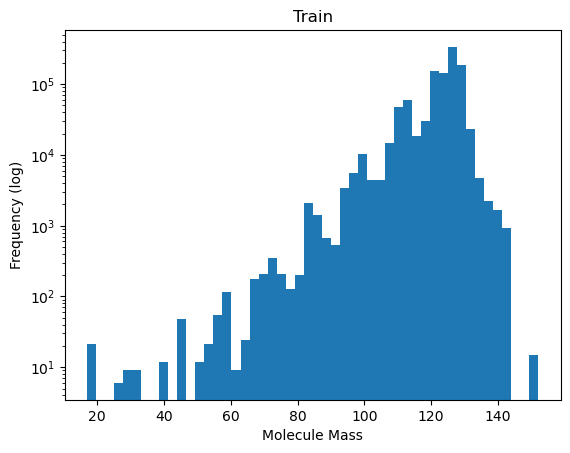

In [126]:
plt.hist(vac_train_subset_merged, bins=50)
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('Molecule Mass')
plt.title('Train')

Text(0.5, 1.0, 'Test')

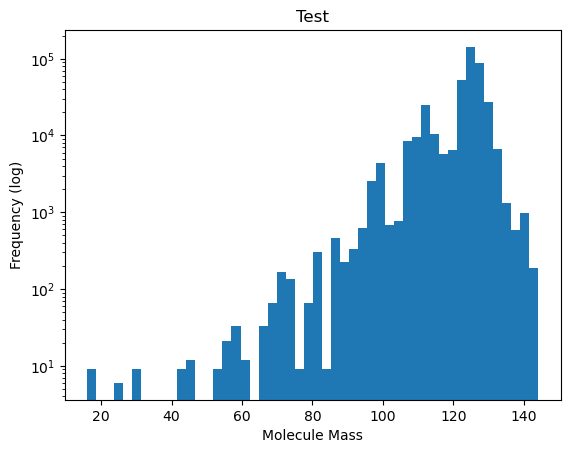

In [127]:
plt.hist(vac_test_subset_merged, bins=50)
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('Molecule Mass')
plt.title('Test')

Text(0.5, 1.0, 'Val')

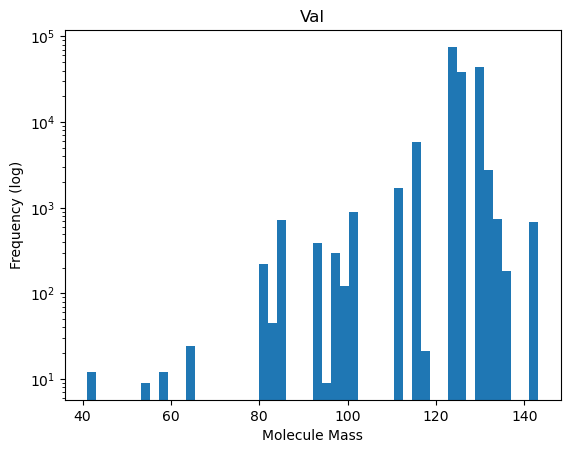

In [128]:
plt.hist(vac_val_subset_merged, bins=50)
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('Molecule Mass')
plt.title('Val')

In [129]:
# vac_test_mass

In [119]:
vac_switch=[ 117.039,
116.20399999999991,
116.15999999999993,
115.09599999999999,
115.095,
112.054,
112.05,
111.14799999999995,
 102.08899999999997,
101.06499999999997,
101.06099999999998,
100.20499999999991,
 99.053,
99.04899999999999,
98.18899999999992,
 95.02300000000001,
94.11699999999996,
85.10599999999997,
84.07799999999997,
83.046,]

In [120]:
for mass in vac_switch:
    vac_val_mass.append(mass)
    vac_val += sorted_length_dict[mass]
    
    vac_test_mass.remove(mass)
    vac_test -= sorted_length_dict[mass]

In [137]:
vac_train_data = [wtd[x] for x in vac_train_mass]
vac_train_data = list(chain.from_iterable(vac_train_data))

vac_val_data = [wtd[x] for x in vac_val_mass]
vac_val_data = list(chain.from_iterable(vac_val_data))

vac_test_data = [wtd[x] for x in vac_test_mass]
vac_test_data = list(chain.from_iterable(vac_test_data))


In [138]:
vac_data = {'train':vac_train_data,
        'val': vac_val_data,
        'test': vac_test_data}

### vac singlet

In [190]:
vac_train_data_singlet = []
for item in vac_train_data:
    if item['spin']==1:
        vac_train_data_singlet.append(item)

In [191]:
vac_val_data_singlet = []
for item in vac_val_data:
    if item['spin']==1:
        vac_val_data_singlet.append(item)

In [192]:
vac_test_data_singlet = []
for item in vac_test_data:
    if item['spin']==1:
        vac_test_data_singlet.append(item)

In [193]:
vac_singlet_data = {'train':vac_train_data_singlet,
        'val': vac_val_data_singlet,
        'test': vac_test_data_singlet}

### vac doublet

In [194]:
vac_train_data_doublet = []
for item in vac_train_data:
    if item['spin']==2:
        vac_train_data_doublet.append(item)

In [195]:
vac_val_data_doublet = []
for item in vac_val_data:
    if item['spin']==2:
        vac_val_data_doublet.append(item)

In [196]:
vac_test_data_doublet = []
for item in vac_test_data:
    if item['spin']==2:
        vac_test_data_doublet.append(item)

In [197]:
vac_doublet_data = {'train':vac_train_data_doublet,
        'val': vac_val_data_doublet,
        'test': vac_test_data_doublet}

# SMD

In [162]:
merged_dist = get_molecule_weight(smd_data)
molecule_weight(smd_data, merged_dist)

100%|██████████| 1624731/1624731 [00:01<00:00, 836754.61it/s]


In [163]:
wtd = weight_to_data(smd_data)

100%|██████████| 1624731/1624731 [00:00<00:00, 2865216.14it/s]


In [164]:
length_dict = {key: len(value) for key, value in wtd.items()}
sorted_length_dict = {k: length_dict[k] for k in sorted(length_dict, reverse=True)}


In [165]:
smd_train_mass = [152.037]
smd_test_mass = [144.09200000000007]
smd_val_mass = [143.1080000000001]

smd_train = sorted_length_dict[152.037] # trackers for dataset sizes
smd_test = sorted_length_dict[144.09200000000007]
smd_val = sorted_length_dict[143.1080000000001]

sorted_length_dict.pop(152.037)
sorted_length_dict.pop(144.09200000000007)
sorted_length_dict.pop(143.1080000000001)


# data is a dict: mass-># of trajs
for mass in sorted_length_dict:
    temp_total = smd_train+smd_val+smd_test
    train_ratio = .65-(smd_train/temp_total)
    test_ratio = .25-(smd_test/temp_total)
    val_ratio = .1-(smd_val/temp_total)
    
    if train_ratio > val_ratio and train_ratio>test_ratio:
        smd_train_mass.append(mass)
        smd_train += sorted_length_dict[mass]
    if val_ratio > train_ratio and val_ratio>test_ratio:
        smd_val_mass.append(mass)
        smd_val += sorted_length_dict[mass]
    if test_ratio > val_ratio and test_ratio>train_ratio:
        smd_test_mass.append(mass)
        smd_test += sorted_length_dict[mass]

In [166]:
smd_train/(smd_train+smd_val+smd_test)

0.6499980612175185

In [167]:
smd_val/(smd_train+smd_val+smd_test)

0.10000547782986845

In [168]:
smd_test/(smd_train+smd_val+smd_test)

0.24999646095261308

In [177]:
smd_train_subset={key: sorted_length_dict[key] for key in smd_train_mass if key in sorted_length_dict}
smd_test_subset={key: sorted_length_dict[key] for key in smd_test_mass if key in sorted_length_dict}
smd_val_subset={key: sorted_length_dict[key] for key in smd_val_mass if key in sorted_length_dict}

smd_train_foo=[[x]*smd_train_subset[x] for x in smd_train_subset]
smd_test_foo=[[x]*smd_test_subset[x] for x in smd_test_subset]
smd_val_foo=[[x]*smd_val_subset[x] for x in smd_val_subset]

from itertools import chain

smd_train_subset_merged = list(chain.from_iterable(smd_train_foo))
smd_test_subset_merged = list(chain.from_iterable(smd_test_foo))
smd_val_subset_merged = list(chain.from_iterable(smd_val_foo))


Text(0.5, 1.0, 'Train')

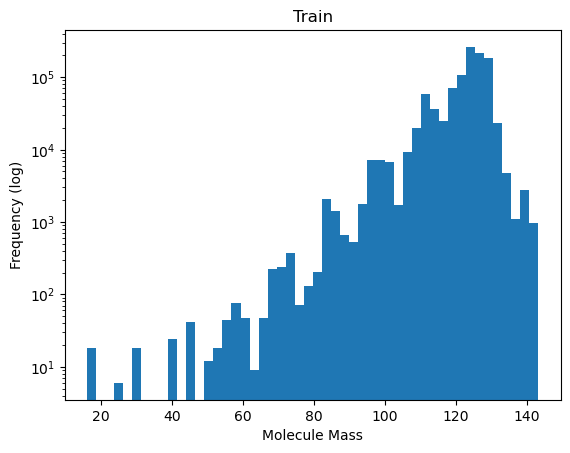

In [178]:
plt.hist(smd_train_subset_merged, bins=50)
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('Molecule Mass')
plt.title('Train')

Text(0.5, 1.0, 'Test')

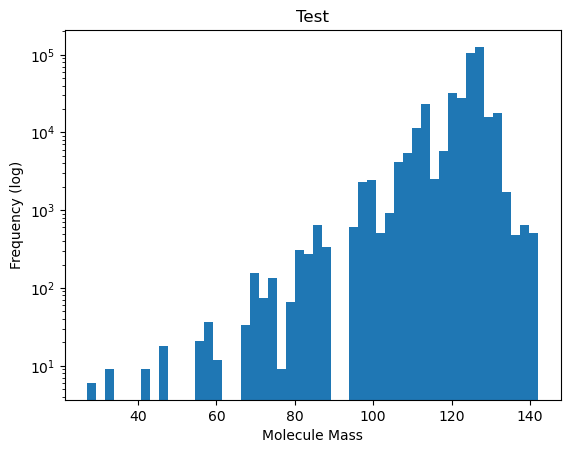

In [179]:
plt.hist(smd_test_subset_merged, bins=50)
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('Molecule Mass')
plt.title('Test')

Text(0.5, 1.0, 'Val')

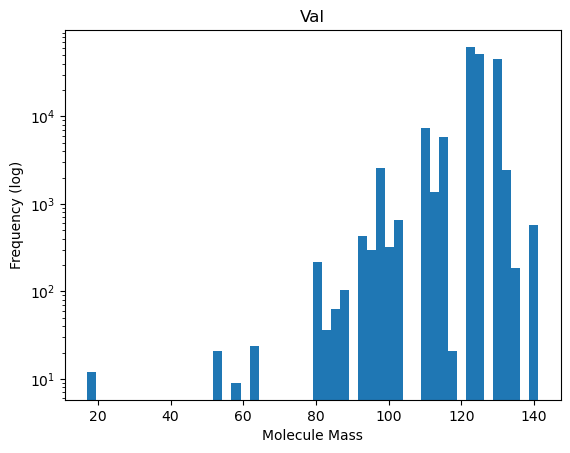

In [180]:
plt.hist(smd_val_subset_merged, bins=50)
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.xlabel('Molecule Mass')
plt.title('Val')

In [176]:
# smd_test_mass
# # 

In [174]:
smd_switch=[117.039,
116.20399999999991,
116.15999999999993,
113.07199999999997,
112.21599999999991,
110.11599999999997,
109.13199999999996,
109.09199999999998,
102.09199999999997,
102.08899999999997,
101.06499999999997,
101.06099999999998,
100.20499999999991,
97.11699999999996,
95.10499999999999,
95.06099999999999,
93.08899999999998,
92.14099999999995,
88.14999999999993,
86.04999999999998,
86.04599999999999,
85.10999999999997,         ]

In [175]:
for mass in smd_switch:
    smd_val_mass.append(mass)
    smd_val += sorted_length_dict[mass]
    
    smd_test_mass.remove(mass)
    smd_test -= sorted_length_dict[mass]

In [186]:
smd_train_data = [wtd[x] for x in smd_train_mass]
smd_train_data = list(chain.from_iterable(smd_train_data))

smd_val_data = [wtd[x] for x in smd_val_mass]
smd_val_data = list(chain.from_iterable(smd_val_data))

smd_test_data = [wtd[x] for x in smd_test_mass]
smd_test_data = list(chain.from_iterable(smd_test_data))


In [187]:
smd_data = {'train':smd_train_data,
        'val': smd_val_data,
        'test': smd_test_data}

### singlet

In [201]:
smd_train_data_singlet = []
for item in smd_train_data:
    if item['spin']==1:
        smd_train_data_singlet.append(item)

smd_val_data_singlet = []
for item in smd_val_data:
    if item['spin']==1:
        smd_val_data_singlet.append(item)
        
smd_test_data_singlet = []
for item in smd_test_data:
    if item['spin']==1:
        smd_test_data_singlet.append(item)
        
smd_singlet_data = {'train':smd_train_data_singlet,
        'val': smd_val_data_singlet,
        'test': smd_test_data_singlet}

### doublet

In [202]:
smd_train_data_doublet = []
for item in smd_train_data:
    if item['spin']==2:
        smd_train_data_doublet.append(item)

smd_val_data_doublet = []
for item in smd_val_data:
    if item['spin']==2:
        smd_val_data_doublet.append(item)
        
smd_test_data_doublet = []
for item in smd_test_data:
    if item['spin']==2:
        smd_test_data_doublet.append(item)
        
smd_doublet_data = {'train':smd_train_data_doublet,
        'val': smd_val_data_doublet,
        'test': smd_test_data_doublet}

# Chunk

In [ ]:
weight_dist = {}
weight_dict = {}
for mol_id in tqdm(bucket):
    species = bucket[mol_id][0]['species']
    species_num = []
    species_sorted = ''.join(sorted(set(species)))
    for element in species:
        species_num.append(elements_dict[element])

    try:
        weight_dist[str(sum(species_num))]+=1
    except KeyError:
        weight_dist[str(sum(species_num))]=1

    try:
        weight_dict[str(sum(species_num))+'_'+species_sorted].append(mol_id)

    except KeyError:
        weight_dict[str(sum(species_num))+'_'+species_sorted] = [mol_id]


In [220]:
len(list(weight_dict.keys()))

1135

In [223]:
# [x for x in list(weight_dict.keys()) if 'F' in x]

In [228]:
for k in [x for x in list(weight_dict.keys()) if 'F' in x]:
    weight_dict[k]

In [234]:
sum([len(weight_dict[k]) for k in [x for x in list(weight_dict.keys()) if 'F' in x]])/len(training)

0.02665372735126691

In [214]:
mol_id_sum_dict={}
weight_dict = {}
for point in tqdm(training):
    species = point['species']
    # if 'F' in species:
    #     print(point)
    #     break
    species_num = 0
    species_sorted = ''.join(sorted(set(species)))
    for element in species:
        species_num+=elements_dict[element]
    try:
        mol_id_sum_dict[point['mol_id']].append(species_num)
    except KeyError:
        mol_id_sum_dict[point['mol_id']] = [species_num]
    try:
        weight_dict[str(species_num)+'_'+species_sorted].append(point)
        # weight_dict[str(species_num)] = list(set(weight_dict[str(species_num)]))
    except KeyError:
        weight_dict[str(species_num)+'_'+species_sorted] = [point]

100%|██████████| 2112425/2112425 [00:07<00:00, 290659.02it/s]


In [126]:
# weight_dict['126.11099999999995'][0]

In [127]:
mol_id_bucket = {}
for point in tqdm(training):
    try:
        mol_id_bucket[point['mol_id']].append(point)
    except KeyError:
        mol_id_bucket[point['mol_id']] = [point]
    

100%|██████████| 2112425/2112425 [00:01<00:00, 1288083.23it/s]


In [128]:
sizes = []
for item in [.01, .05, .1, .25, .5, .75]:
    temp_size = round(len(training)*item)
    sizes.append(temp_size)
sizes

[21124, 105621, 211242, 528106, 1056212, 1584319]

In [199]:
chunks = []
count = 0

for size in tqdm(sizes):
    # print("size:", size)
    chunked_mol_id_data = []
    for i in range(len(training)):
        if count<size:
            for key in weight_dict:
                if len(weight_dict[key])!=0:
                    count+=1
                    chunked_mol_id_data.append(weight_dict[key][0])
                    weight_dict[key] = weight_dict[key][1:]

                else:
                    pass
            weight_dict = {k: v for (k,v) in weight_dict.items() if len(v)!=0}

        else:
            break
    # print('count:', count)
    # print(len(chunked_mol_id_data))
    chunks.append(chunked_mol_id_data)

100%|██████████| 6/6 [06:08<00:00, 61.34s/it] 


In [170]:
len(chunks[0])+len(chunks[1])/len(training)

21317.04005870031

In [154]:
def chunk_train_multiple_sp(data: list, percentage: list):
    """
    Percentage: list of percentages e.g., [.05, .1, .25, .5, .75]
    This is different from traj. Sp the mol ids are not unique. As a result, we treat every point a unique so that when we sample from weight dict we do not sample the id, but the point. 
    
    """
    mol_id_bucket = {}
    for point in tqdm(data):
        try:
            mol_id_bucket[point['mol_id']].append(point)
        except KeyError:
            mol_id_bucket[point['mol_id']] = [point]
    
    
    elements_dict = read_elements('/pscratch/sd/m/mavaylon/sam_ldrd/radqm9_pipeline/src/radqm9_pipeline/modules/elements.pkl')
    
    ##################
    # Create a weight dictionary such that the keys are the unique weights using atomic mass of the molecule
    # as a float and the values are list of mol_ids that correspond to said weight. 
    ##################
    mol_id_sum_dict={}
    weight_dict = {}
    for point in tqdm(data):
        species = point['species']
        species_num = 0
        for element in species:
            species_num+=elements_dict[element]
        try:
            mol_id_sum_dict[point['mol_id']].append(species_num)
        except KeyError:
            mol_id_sum_dict[point['mol_id']] = [species_num]
        try:
            weight_dict[str(species_num)].append(point)
            # weight_dict[str(species_num)] = list(set(weight_dict[str(species_num)]))
        except KeyError:
            weight_dict[str(species_num)] = [point]
    ##################
    # Calculate total data points
    ##################
    total=len(data)
    
    ##################
    # Calculate the size for the data chunk for each percentage
    ##################
    sizes = []
    for item in percentage:
        temp_size = round(total*item)
        sizes.append(temp_size)
    
    ##################
    # Get the chunked mol_ids for each size
    ##################
    chunks = []
    count = 0
    
    for size in tqdm(sizes):
        print("size:", size)
        chunked_mol_id_data = []
        for i in tqdm(range(total)):
            if count<size:
                for key in weight_dict:
                    if len(weight_dict[key])!=0:
                        count+=1
                        chunked_mol_id_data.append(weight_dict[key][0])
                        weight_dict[key] = weight_dict[key][1:]

                    else:
                        pass
                weight_dict = {k: v for (k,v) in weight_dict.items() if len(v)!=0}

            else:
                break
        # print('count:', count)
        # print(len(chunked_mol_id_data))
        chunks.append(chunked_mol_id_data)
        
#         for item in chunks:
#             print(len(item))
        
#     chunked_data = []
#     for chunk_set in tqdm(chunks):
#         chunk = []
#         for item in tqdm(chunk_set):
#             chunk+=mol_id_bucket[item]
#         chunked_data.append(chunk)
    
    return chunks, weight_dict, mol_id_sum_dict


In [147]:
sizes = []
for item in [.01, .05, .1, .25, .5, .75]:
    temp_size = round(len(training)*item)
    sizes.append(temp_size)
sizes

[21124, 105621, 211242, 528106, 1056212, 1584319]

In [116]:
21124/len(training)

0.009999881652603052

In [148]:
tt, w,e=chunk_train_multiple(training, [.01, .05, .1, .25, .5, .75])

  0%|          | 0/6 [00:00<?, ?it/s]

size: 21124



  0%|          | 1/2112425 [00:00<4:57:30, 118.34it/s]


1135
size: 105621



  0%|          | 1/2112425 [00:00<4:35:10, 127.95it/s]


1135
1121
size: 211242



  0%|          | 1/2112425 [00:00<4:30:51, 129.98it/s]


1135
1121
1060
size: 528106



  0%|          | 4/2112425 [00:00<3:51:38, 151.99it/s]


1135
1121
1060
3549
size: 1056212



 83%|████████▎ | 5/6 [00:00<00:00, 47.05it/s]

1135
1121
1060
3549
5820
size: 1584319



100%|██████████| 6/6 [00:00<00:00, 38.21it/s]


1135
1121
1060
3549
5820
5482


100%|██████████| 1135/1135 [00:00<00:00, 887001.13it/s]

100%|██████████| 1121/1121 [00:00<00:00, 907511.06it/s]

100%|██████████| 1060/1060 [00:00<00:00, 875017.17it/s]

100%|██████████| 3549/3549 [00:00<00:00, 926988.72it/s]

100%|██████████| 5820/5820 [00:00<00:00, 932601.69it/s]

100%|██████████| 6/6 [00:00<00:00, 208.99it/s]


In [200]:
chunked_data = {0: chunks[0],
                1: chunks[0] + chunks[1],
                2: chunks[0] + chunks[1] +chunks[2],
                3: chunks[0] + chunks[1] +chunks[2] + chunks[3],
                4: chunks[0] + chunks[1] +chunks[2] + chunks[3] + chunks[4],
                5: chunks[0] + chunks[1] +chunks[2] + chunks[3] + chunks[4] +chunks[5]}

In [235]:
len(chunked_data[0])/len(training)

0.010323680130655526

In [236]:
len(chunked_data[1])/len(training)

0.050245097459081386

In [237]:
len(chunked_data[2])/len(training)

0.10003810786181758

In [238]:
len(chunked_data[3])/len(training)

0.2500874587263453

In [239]:
len(chunked_data[4])/len(training)

0.5000158585511911

In [240]:
len(chunked_data[5])/len(training)

0.7500105329183284

# Build Atoms

In [38]:
training[0].keys()

dict_keys(['mol_id', 'species', 'optimized_parent_charge_spin', 'charge', 'spin', 'solvent', 'geometry', 'energy', 'precise_gradient', 'gradient', 'mulliken_partial_charges', 'mulliken_partial_spins', 'resp_partial_charges', 'resp_dipole_moment', 'nbo_partial_charges', 'nbo_partial_spins', 'dipole_moment', 'charge_spin', 'sp_config_type', 'dup_identifier'])

In [54]:
def build_minimal_atoms(data: dict,
                energy: str = None,
                forces: str = None,
                charge:str = None,
                spin:str = None,
                train = False) -> ase.Atoms:
    """ 
    Populate Atoms class with atoms in molecule.
        atoms.info : global variables
        atoms.array : variables for individual atoms
        
    Both "energy" and "forces" are the dict strings in data.
    """
    atom_list = []
    atoms = ase.atoms.Atoms(
        symbols=data['species'],
        positions=data['geometry']
    )
    if energy is not None:
        atoms.info['energy'] = data[energy]
    if forces is not None:
        atoms.arrays['forces'] = np.array(data[forces])
    # atoms.arrays['precise_forces'] = np.array(data['precise_gradient'])                                      
    if charge is not None:
         atoms.info['charge'] = data[charge]
    if spin is not None:
        atoms.info['spin'] = data[spin]
    # if train:
    #     atoms.info['chunk'] = data['chunk']

    # atoms.info['mulliken_partial_charges'] = data['mulliken_partial_charges']
    # atoms.info['mulliken_partial_spins'] = data['mulliken_partial_spins']
    atoms.info['mol_id'] = data['mol_id']
    # atoms.info['resp_partial_charges'] = data['resp_partial_charges'] 
    # atoms.info['resp_dipole_moment'] = data['resp_dipole_moment']
    # atoms.info['nbo_partial_charges'] = data['nbo_partial_charges']
    # atoms.info['nbo_partial_spins'] = data['nbo_partial_spins'] 
    # atoms.info['optimized_parent_charge_spin'] = data['optimized_parent_charge_spin'] 
    atoms.info['optimized_parent_charge']= data['optimized_parent_charge_spin'] [0]
    atoms.info['optimized_parent_spin']= data['optimized_parent_charge_spin'] [0]
    # atoms.info['charge_spin'] = data['charge_spin'] 
    # atoms.info['dipole_moment'] = data['dipole_moment']
    atoms.info['solvent'] = data['solvent']

    atom_list.append(atoms)
            
    return atom_list

In [26]:
def build_atoms(data: dict,
                energy: str = None,
                forces: str = None,
                charge:str = None,
                spin:str = None,
                train = False) -> ase.Atoms:
    """ 
    Populate Atoms class with atoms in molecule.
        atoms.info : global variables
        atoms.array : variables for individual atoms
        
    Both "energy" and "forces" are the dict strings in data.
    """
    atom_list = []
    atoms = ase.atoms.Atoms(
        symbols=data['species'],
        positions=data['geometry']
    )
    if energy is not None:
        atoms.info['energy'] = data[energy]
    if forces is not None:
        atoms.arrays['forces'] = np.array(data[forces])
    # atoms.arrays['precise_forces'] = np.array(data['precise_gradient'])                                      
    if charge is not None:
         atoms.info['charge'] = data[charge]
    if spin is not None:
        atoms.info['spin'] = data[spin]
    # if train:
    #     atoms.info['chunk'] = data['chunk']

    # atoms.info['mulliken_partial_charges'] = data['mulliken_partial_charges']
    # atoms.info['mulliken_partial_spins'] = data['mulliken_partial_spins']
    atoms.info['mol_id'] = data['mol_id']
    # atoms.info['resp_partial_charges'] = data['resp_partial_charges'] 
    # atoms.info['resp_dipole_moment'] = data['resp_dipole_moment']
    # atoms.info['nbo_partial_charges'] = data['nbo_partial_charges']
    # atoms.info['nbo_partial_spins'] = data['nbo_partial_spins'] 
    # atoms.info['optimized_parent_charge_spin'] = data['optimized_parent_charge_spin'] 
    atoms.info['optimized_parent_charge']= data['optimized_parent_charge_spin'] [0]
    atoms.info['optimized_parent_spin']= data['optimized_parent_charge_spin'] [0]
    # atoms.info['charge_spin'] = data['charge_spin'] 
    # atoms.info['dipole_moment'] = data['dipole_moment']
    atoms.info['solvent'] = data['solvent']

    atom_list.append(atoms)
            
    return atom_list

In [27]:
def build_atoms_iterator(data: list,
                         train=False):
    """
    This method assumes the data has been validated. This will create ASE atoms to be written.
    
    The input needs to be a list of lists that contain the event dictionaries. Each inner list needs to represent all the events for a single
    mol_id.
    """
    data_set=[]
    for point in tqdm(data):
        atoms=build_atoms(point, energy='energy', forces='gradient', charge='charge', spin='spin', train=train)
        data_set+=atoms
    return data_set

In [133]:
def build_minimal_atoms_iterator(data: list,
                         train=False):
    """
    This method assumes the data has been validated. This will create ASE atoms to be written.
    
    The input needs to be a list of lists that contain the event dictionaries. Each inner list needs to represent all the events for a single
    mol_id.
    """
    data_set=[]
    for point in tqdm(data):
        atoms=build_minimal_atoms(point, energy='energy', forces='gradient', charge='charge', spin='spin', train=train)
        data_set+=atoms
    return data_set

In [135]:
vac_data['train'][0]

152.037

In [139]:
vac_build = {}
for split in vac_data:
    if split == 'train':
        vac_build[split] = build_minimal_atoms_iterator(vac_data[split], train=True)
    else:
        vac_build[split] = build_minimal_atoms_iterator(vac_data[split])

100%|██████████| 396247/396247 [00:12<00:00, 30536.68it/s]


In [188]:
smd_build = {}
for split in smd_data:
    if split == 'train':
        smd_build[split] = build_minimal_atoms_iterator(smd_data[split], train=True)
    else:
        smd_build[split] = build_minimal_atoms_iterator(smd_data[split])

100%|██████████| 387160/387160 [00:12<00:00, 30074.40it/s]


In [140]:
def create_dataset(data: dict,
                   file_name:str,
                   path:str):
    """
    This method will handle the I/O for writing the data to xyz files to the path provided.
    """
    train_data = data['train']
    val_data = data['val']
    test_data = data['test']
    
    train_file = os.path.join(path,file_name+'_train.xyz')
    ase.io.write(train_file, train_data,format="extxyz")
     
    val_file = os.path.join(path,file_name+'_val.xyz')
    ase.io.write(val_file, val_data,format="extxyz")
    
    test_file = os.path.join(path,file_name+'_test.xyz')
    ase.io.write(test_file, test_data,format="extxyz")

In [141]:
#to xyz
create_dataset(vac_build, 'rad_qm9_65_25_10_minimalfeatures_single_point_vacuum_2024_5_12', '/pscratch/sd/m/mavaylon/chem_final_data/SP/Full_data/vac/')

In [189]:
#to xyz
create_dataset(smd_build, 'rad_qm9_65_25_10_minimalfeatures_single_point_smd_2024_5_12', '/pscratch/sd/m/mavaylon/chem_final_data/SP/Full_data/smd/')

## Write doublet_data

In [54]:
# vac_doublet_data

In [55]:
#smd_doublet_data

In [199]:
vac_build_doublet_data = {}
for split in vac_doublet_data:
    if split == 'train':
        vac_build_doublet_data[split] = build_minimal_atoms_iterator(vac_doublet_data[split], train=True)
    else:
        vac_build_doublet_data[split] = build_minimal_atoms_iterator(vac_doublet_data[split])

100%|██████████| 197105/197105 [00:07<00:00, 26026.12it/s]


In [203]:
smd_build_doublet_data = {}
for split in smd_doublet_data:
    if split == 'train':
        smd_build_doublet_data[split] = build_minimal_atoms_iterator(smd_doublet_data[split], train=True)
    else:
        smd_build_doublet_data[split] = build_minimal_atoms_iterator(smd_doublet_data[split])

100%|██████████| 192594/192594 [00:06<00:00, 29222.92it/s]


In [200]:
#to xyz
create_dataset(vac_build_doublet_data, 'rad_qm9_65_25_10_minimal_vac_single_point_doublet_2024_5_13', '/pscratch/sd/m/mavaylon/chem_final_data/SP/Doublet/vac/')

In [204]:
#to xyz
create_dataset(smd_build_doublet_data, 'rad_qm9_65_25_10__minimal_smd_single_point_doublet_2024_5_13', '/pscratch/sd/m/mavaylon/chem_final_data/SP/Doublet/smd/')

## Write Singlet data

In [ ]:
# vac_singlet_data
# smd_singlet_data

In [205]:
vac_build_singlet_data = {}
for split in vac_singlet_data:
    if split == 'train':
        vac_build_singlet_data[split] = build_minimal_atoms_iterator(vac_singlet_data[split], train=True)
    else:
        vac_build_singlet_data[split] = build_minimal_atoms_iterator(vac_singlet_data[split])

100%|██████████| 167822/167822 [00:05<00:00, 28661.23it/s]


In [207]:
smd_build_singlet_data = {}
for split in smd_singlet_data:
    if split == 'train':
        smd_build_singlet_data[split] = build_minimal_atoms_iterator(smd_singlet_data[split], train=True)
    else:
        smd_build_singlet_data[split] = build_minimal_atoms_iterator(smd_singlet_data[split])

100%|██████████| 163926/163926 [00:05<00:00, 28392.45it/s]


In [208]:
#to xyz
create_dataset(vac_build_singlet_data, 'rad_qm9_65_25_10_minimal_vac_single_point_singlet_2024_5_13', '/pscratch/sd/m/mavaylon/chem_final_data/SP/Singlet/vac/')

In [209]:
#to xyz
create_dataset(smd_build_singlet_data, 'rad_qm9_65_25_10__minimal_smd_single_point_singlet_2024_5_13', '/pscratch/sd/m/mavaylon/chem_final_data/SP/Singlet/smd/')

## Write Chunk

In [249]:
chunked_build = build_atoms_iterator(chunked_data[5], train=True)

100%|██████████| 1584341/1584341 [00:51<00:00, 30968.24it/s]


In [250]:
chunk_file = os.path.join('/pscratch/sd/m/mavaylon/single_point/rad_qm9_65_15_10_single_point_chunk_75'+'_train.xyz')
ase.io.write(chunk_file, chunked_build,format="extxyz")

# Visuals

In [68]:
def atom_type_plot(data: list):
    """
    Takes in a list of data points and creates graph to visualize the frequency of each atom type.
    """
    atom_dict={}
    for point in data:
        for atom in point['species']:
            try:
                atom_dict[atom]+=1
            except KeyError:
                atom_dict[atom]=0
    return atom_dict  

In [ ]:
[.01, .05, .1, .25, .5, .75]

In [203]:
dc = atom_type_plot(chunked_data[1])

In [204]:
len(chunked_data[1])/len(training)

0.050245097459081386

In [205]:
dc

{'O': 126470, 'C': 518880, 'H': 689682, 'N': 189268, 'F': 31253}

In [69]:
d1=atom_type_plot(vac_training)

In [70]:
d3=atom_type_plot(vac_test)

In [71]:
d2=atom_type_plot(vac_val)

In [72]:
from collections import Counter
z = dict(Counter(d1)+Counter(d2)+Counter(d3))

In [73]:
# {k: float(dc[k])/dict(Counter(d1))[k] for k in d1}


In [74]:
{k: float(d1[k])/z[k] for k in d1}


{'O': 0.6500548207667325,
 'C': 0.6500490149994052,
 'H': 0.6500305108133662,
 'N': 0.650128573841613,
 'F': 0.651060661317773}

In [75]:
{k: float(d2[k])/z[k] for k in d1}


{'O': 0.25148470154534164,
 'C': 0.25131712768468745,
 'H': 0.25121067111864465,
 'N': 0.2529065244834821,
 'F': 0.26461828349136884}

In [76]:
{k: float(d3[k])/z[k] for k in d1}


{'O': 0.0984604776879259,
 'C': 0.09863385731590739,
 'H': 0.0987588180679892,
 'N': 0.09696490167490487,
 'F': 0.08432105519085825}

In [168]:
# [x for x in merged_data if x['charge_spin']=='-1_2']

In [6]:
bucket_mol_id={}
for data in tqdm(merged_data):
    try:
        data['charge_spin_solvent'] = str(data['charge'])+'_'+str(data['spin'])+'_'+data['solvent']
        data['charge_spin'] = str(data['charge'])+'_'+str(data['spin'])
        bucket_mol_id[data['mol_id']].append(data)
    except KeyError:
        data['charge_spin_solvent'] = str(data['charge'])+'_'+str(data['spin'])+'_'+data['solvent']
        data['charge_spin'] = str(data['charge'])+'_'+str(data['spin'])
        bucket_mol_id[data['mol_id']] = [data]

100%|██████████| 3518823/3518823 [00:05<00:00, 692514.09it/s]


In [24]:
temp=[x for x in bucket_mol_id[1648] if x['solvent']=='SMD']
sub=[x for x in temp if x['charge_spin']=='0_1']

In [25]:
len(sub)

2

In [6]:
# sub

In [7]:
ids_missing=[]
for mol_id in tqdm(bucket_mol_id):
    if len(bucket_mol_id[mol_id])<24:
        ids_missing.append(mol_id)

100%|██████████| 133882/133882 [00:00<00:00, 1922502.42it/s]


In [15]:
# ids_missing #total 2305283

In [8]:
len(set(ids_missing)) #missing 101975

11509

In [11]:
missing_data_c=0
for mid in ids_missing:
    missing_data_c+=len(bucket_mol_id[mid])

In [9]:
missing_data_q=0
for mid in ids_missing:
    missing_data_q+=24-len(bucket_mol_id[mid])

In [10]:
missing_data_q/

75702

In [44]:
name_parse = name.split('+-_')[1]
optimized_charge = name_parse[0]
current_charge = name_parse[-1]

In [45]:
structures = {}

'0'

In [157]:
t=type_tagger(merged_data)


100%|██████████| 2305283/2305283 [00:04<00:00, 549268.39it/s]


In [158]:
t==None

True

In [115]:
'128916_qm9+-_0_FFOpt smd -1 2'.split('+-_')[1].split(' ')[-2]

'-1'

In [114]:
'001648_qm9+-_1 smd 0'.split('+-_')[1].split(' ')

['1', 'smd', '0']

In [82]:
t.split('+-_')[1].split(' ')[0].split('_'

['0', 'FFOpt']

In [159]:
def check_missing_optimized_charge_spin(data: list):
    # check to see every data point has a optimized_charge_spin
    missing = []
    for item in tqdm(merged_data):
        try:
            item['optimized_charge_spin']
        except KeyError:
            missing.append(item)
    if len(missing)>0:
        return missing
    else: 
        return None

In [44]:
check = check_missing_optimized_charge_spin(merged_data)
check==None

100%|██████████| 2305283/2305283 [00:00<00:00, 4009973.95it/s]


True

In [160]:
def check_missing_sp_config_type(data: list):
    # check to see every data point has a optimized_charge_spin
    missing = []
    for item in tqdm(merged_data):
        try:
            item['sp_config_type']
        except KeyError:
            missing.append(item)
    if len(missing)>0:
        return missing
    else: 
        return None

In [161]:
check = check_missing_sp_config_type(merged_data)
check==None

100%|██████████| 2305283/2305283 [00:00<00:00, 3191596.90it/s]


True

In [169]:
def force_magnitude_filter_flattened_sp(cutoff: float,
                                     data: list):
    """
    This method returns both data that meets the cuttoff value and data that is equal to or above the cuttoff value.
    
    Returns: List
    """
    original_size = len(data)
    
    for item in tqdm(data):
        forces = item['gradient']
        for atom in forces:
            res = np.sqrt(sum([i**2 for i in atom]))
            if res >= cutoff:
                print('y')
                data.remove(item)
    
    return original_size, len(data)

In [170]:
orig_size, filtered_size = force_magnitude_filter_flattened_sp(10.0, merged_data)

100%|██████████| 2305283/2305283 [00:53<00:00, 42769.77it/s]


In [171]:
orig_size

2305283

In [172]:
filtered_size

2305283